Predicción de la resistencia del concreto
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-modeling/blob/master/10-neuralnet-R-strength-concrete.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-modeling/blob/master/10-neuralnet-R-strength-concrete.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-modeling/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-modeling/blob/master/readme.md)

# Definición del problema real

El concreto es uno de los materiales más usados en construcción. Es fabricado por la mezcla de varios elementos, la cual, al secarse, forma una masa dura muy resistente a la compresión. Uno de los principales problemas es que la mezcla puede demorarse varios meses en secar, y resulta particularmente importante el poder realizar pronósticos de la resistencia que alcanzará, tanto para fines de control como para verificar las restricciones de diseño.  

# Definición del problema en términos de los datos

La muestra contiene 1030 mediciones de concretos con ocho características que decriben los componentes usados en la mezcla. Se piensa que estas ocho características tienen una relación no lineal con la resistencia a la compresión final que tiene el concreto. El problema consiste en construir un modelo de regresión no lineal que permita pronósticar la resistencia del concreto con base en ellas. 

* Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable 


* Bla st Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable 


* Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable 
  
  
* Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable 
  
  
* Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable 


* Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable 


* Fine Aggregate (component 7)	-- quantitative -- kg in a m3 mixture -- Input Variable 


* Age -- quantitative -- Day (1~365) -- Input Variable 


* Concrete compressive strength -- quantitative -- MPa -- Output Variable 

# Exploración

In [2]:
# carga de los datos
concrete <- read.csv("data/concrete.csv")
str(concrete)
# todas las variables son numéricas

'data.frame':	1030 obs. of  9 variables:
 $ cement      : num  540 540 332 332 199 ...
 $ slag        : num  0 0 142 142 132 ...
 $ ash         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ water       : num  162 162 228 228 192 228 228 228 228 228 ...
 $ superplastic: num  2.5 2.5 0 0 0 0 0 0 0 0 ...
 $ coarseagg   : num  1040 1055 932 932 978 ...
 $ fineagg     : num  676 676 594 594 826 ...
 $ age         : int  28 28 270 365 360 90 365 28 28 28 ...
 $ strength    : num  80 61.9 40.3 41 44.3 ...


In [3]:
# Información relevante de la resistencia
summary(concrete$strength)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.33   23.71   34.45   35.82   46.13   82.60 

In [4]:
# Se escalan todas las variables al rango [0, 1]
# para evitar problemas asociados a la escala

normalize <- function(x) {
    return((x - min(x)) / (max(x) - min(x)))
}

concrete_norm <- as.data.frame(lapply(concrete, normalize))

In [5]:
# Se revisan algunas variables del data.frame
summary(concrete_norm$strength)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2664  0.4001  0.4172  0.5457  1.0000 

In [6]:
summary(concrete_norm$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01648 0.07418 0.12270 0.15110 1.00000 

# Metodología

Una red neuronal artificial es un modelo matemático de regresión no lineal inspirado en las redes de neuronas del cerebro. Una neurona esta representada matemáticamente como se indica en la siguiente figura.

![alt text](images/neurona.jpg)

*  $x_1$, ..., $x_n$ representan las entradas a la neurona.


* $w_0$, ..., $w_n$ representan los pesos ajustables (parámetros de la neurona).


* $+1$ es una entrada unitaria.


* $\sigma()$ representa la función de activación de la neurona, que para este caso particular es la función logística, definida como:


$$ \sigma(u) = \frac{1}{1+\exp(-u)} $$


De esta forma, el modelo matemático de una neurona es:

$$y = \sigma \big(w_0 + \sum_{i=1}^n w_i*x_i    \big)$$

Note que la parte entre paréntesis es equivalente a un modelo de regresión lineal, por lo que la neurona puede interpretarse matemáticamente como un modelo  de regresión no lineal.

Al unir varias neuronas, tal que las salidas de unas sean las entradas de otras, se pueden formar diferentes tipos de arquitecturas de redes neuronales. La más común es la red de propagación hacia adelante, en la que cada capa de neuronas se conecta con la siguiente. La figura de abajo presenta una arquitectura con dos entradas ($x_1$ y $x_2$), una capa oculta de procesamiento con dos neuronas y una variable de salida ($y$).

![alt text](images/nnet.jpg)

El modelo anterior es equivalente a la siguiente ecuación de regresión con $H=2$ e $I=2$:

$$y = b_2 + \sum_{h=1}^H w_2[h,1] * \sigma \Big( b_1[h] + \sum_{i=1}^I w_1[i,h] * x_i \Big)$$ 

**Ejercicio.--** Identifique los parámetros del modelo de regresión en el esquema ilustrativo de la red neuronal. 

Si se tiene un conjunto de ejemplos, el proceso de entrenamiento consiste en encontrar los parámetros de la red neuronal ($b_1[h]$, $b_2$, $w_1[i,h]$, $w_2[h,1]$, para $h$ = 1, ..., H, y $i$ = 1, ..., $I$, tal que se minimice alguna medida de error, tal como en el caso de la regresión linea. 

# Entrenamiento del modelo

In [7]:
# se usa el 75% de los datos para entrenamiento
concrete_train <- concrete_norm[1:773, ]
concrete_test <- concrete_norm[774:1030, ]

In [8]:
# install.packages("neuralnet")
library(neuralnet)

In [9]:
# el modelo se especifica tal como en los 
# modelos de regresión lineal
concrete_model <- neuralnet(strength ~ cement + slag
                            + ash + water + superplastic + 
                            coarseagg + fineagg + age, 
                            data = concrete_train)
# por defecto, el modelo tiene una neurona en la capa oculta

In [10]:
# esta función no realiza la gráfica en jupyter!
options(repr.plot.width=10, repr.plot.height=6)
plot(concrete_model) 

# Evaluación del modelo

In [11]:
# Se analiza el entrenamiento
# variable de salida
summary(concrete_train$strength)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.2639841 0.4163448 0.4303287 0.5839043 1.0000000 

In [12]:
# pronóstico del modelo para la muestra de 
# entrenamiento
summary(unlist(concrete_model$net.result))

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
0.07774661 0.25946352 0.46250508 0.43031976 0.60544496 0.67499057 

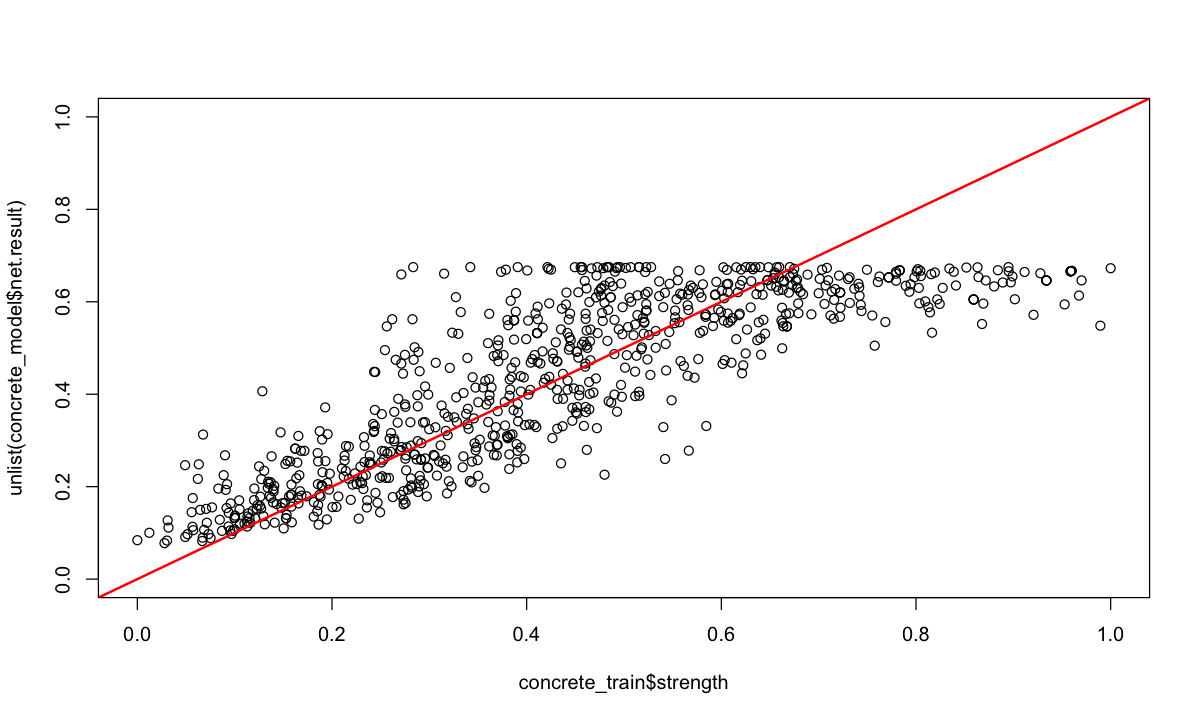

In [13]:
# si el pronóstico es perfecto, los puntos
# deben estar sobre la linea a 45 grados.
plot(concrete_train$strength, 
     unlist(concrete_model$net.result),
     xlim=c(0,1),
     ylim=c(0,1))
abline(a=0,b=1, col='red', lwd=2)

In [14]:
# evaluación de la muestra de prueba
model_results <- compute(concrete_model, concrete_test[1:8])
predicted_strength <- model_results$net.result
cor(predicted_strength, concrete_test$strength)

0.723554743


In [15]:
# se define el error medio absoluto
MAE <- function(actual, predicted) {
    mean(abs(actual - predicted))
}

In [16]:
MAE(predicted_strength, concrete_test$strength)

[1] 0.08489752787

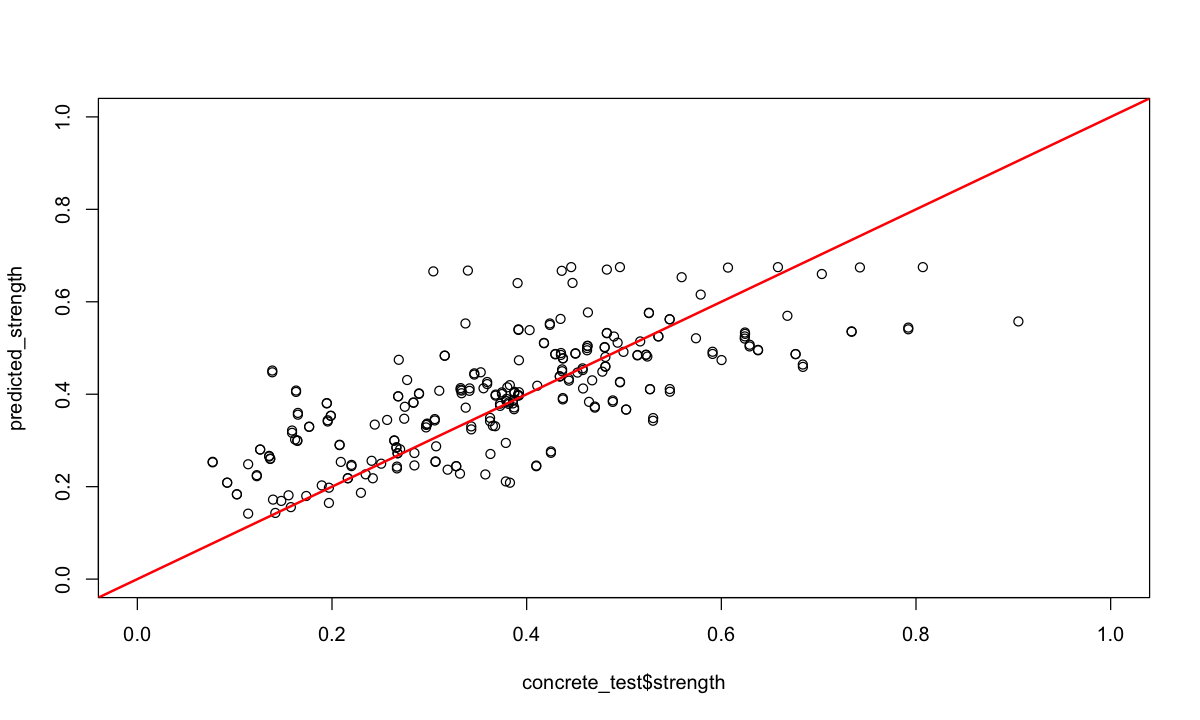

In [17]:
# si el pronóstico es perfecto, los puntos
# deben estar sobre la linea a 45 grados.
plot(concrete_test$strength, 
     predicted_strength,
     xlim=c(0,1),
     ylim=c(0,1))
abline(a=0,b=1, col='red', lwd=2)

# Mejora del modelo

In [18]:
concrete_model2 <- neuralnet(strength ~ cement + slag +
                               ash + water + superplastic +
                               coarseagg + fineagg + age,
                               data = concrete_train, 
                             hidden = 5) # cantidad de neuronas en la capa oculta

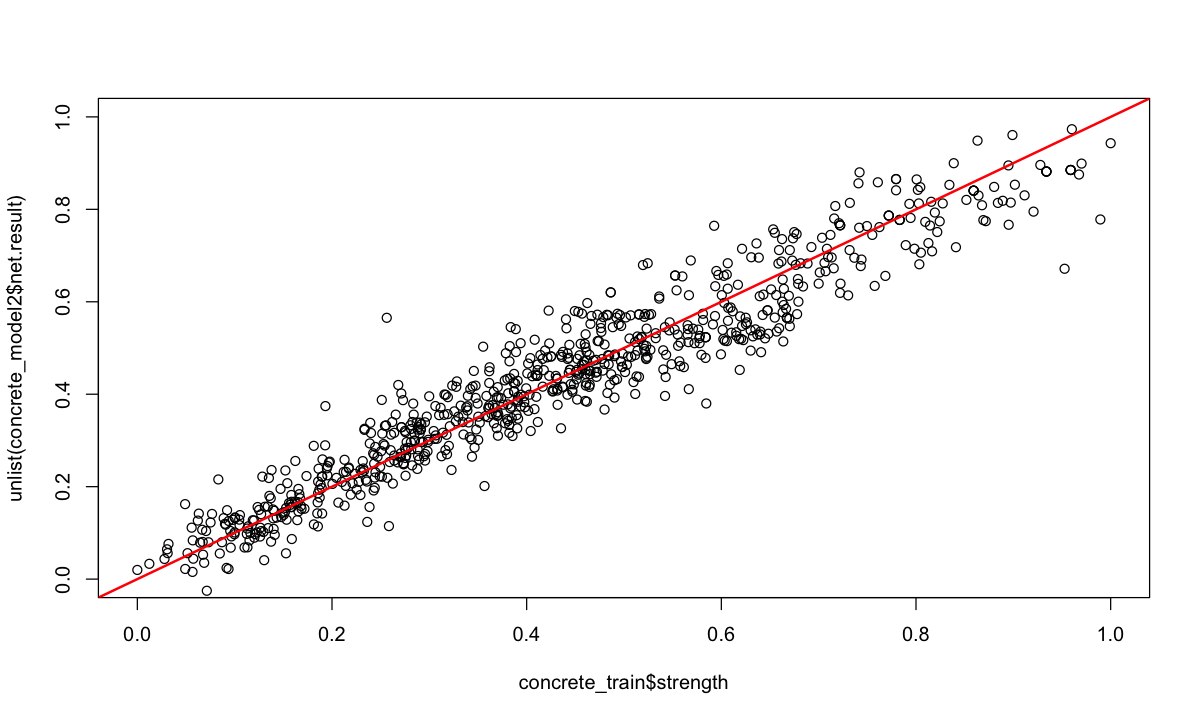

In [19]:
# si el pronóstico es perfecto, los puntos
# deben estar sobre la linea a 45 grados.
# Note que el pronóstico es mucho mejor
# que en el caso anterior.
plot(concrete_train$strength, 
     unlist(concrete_model2$net.result),
     xlim=c(0,1),
     ylim=c(0,1))
abline(a=0,b=1, col='red', lwd=2)

In [20]:
# no genera la gráfica en jupyter!
plot(concrete_model2)

In [21]:
model_results2 <- compute(concrete_model2, concrete_test[1:8])
predicted_strength2 <- model_results2$net.result
cor(predicted_strength2, concrete_test$strength)

0.7102919638


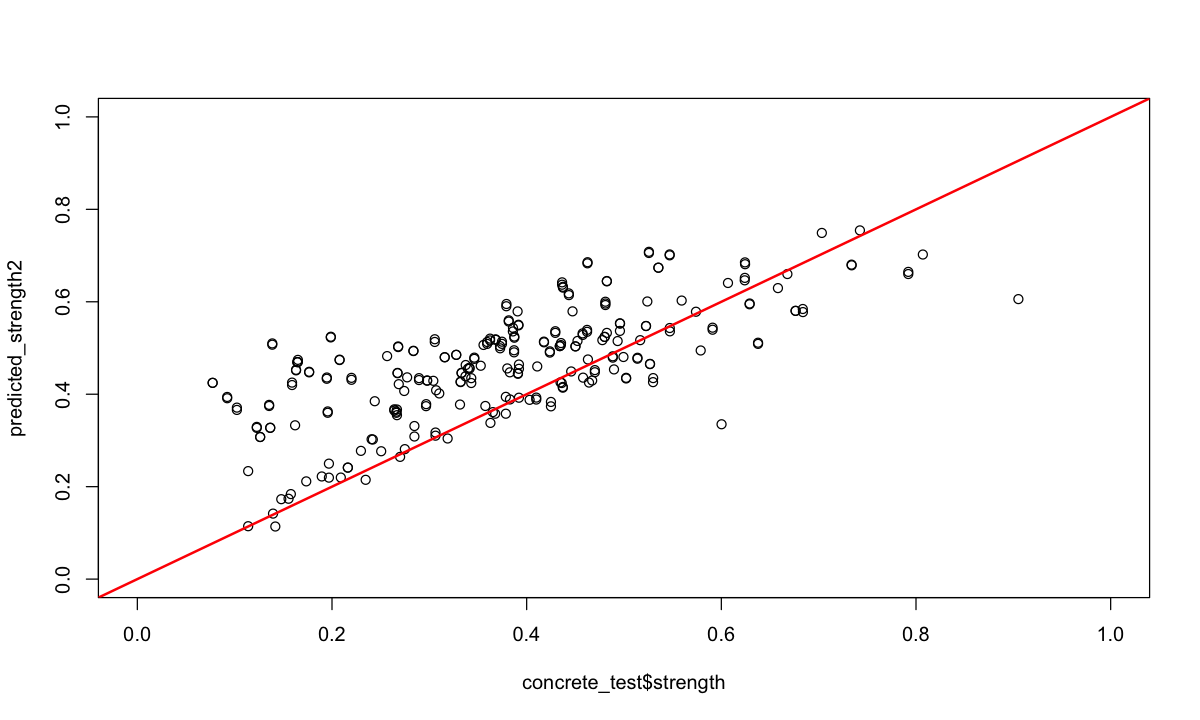

In [22]:
# compare esta gráfica con la original
plot(concrete_test$strength, 
     predicted_strength2,
     xlim=c(0,1),
     ylim=c(0,1))
abline(a=0,b=1, col='red', lwd=2)

**Ejercicio.--** Cómo se puede determinar el número óptimo de las neuronas de la capa oculta?

**Ejercicio.--** Este es un problema de optimización no lineal complejo con múltiples mínimos locales. Cómo debería realizarse la optimización del modelo?

---

Predicción de la resistencia del concreto
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-modeling/blob/master/10-neuralnet-R-strength-concrete.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-modeling/blob/master/10-neuralnet-R-strength-concrete.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-modeling/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-modeling/blob/master/readme.md)